In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, make_scorer, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thilokreddyanugu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('test.csv', encoding='latin1')
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [4]:
df = df[['text', 'sentiment', 'Country']]
df.dropna(inplace=True)
df.head()

,text,sentiment,Country
0,Last session of the day http://twitpic.com/67ezh,neutral,Afghanistan
1,Shanghai is also really exciting (precisely -...,positive,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,Algeria
3,happy bday!,positive,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,Angola


In [5]:
df['sentiment'] = df['sentiment'].replace({'positive': 2, 'neutral': 1, 'negative': 0})
df.head()

,text,sentiment,Country
0,Last session of the day http://twitpic.com/67ezh,1,Afghanistan
1,Shanghai is also really exciting (precisely -...,2,Albania
2,"Recession hit Veronique Branquinho, she has to...",0,Algeria
3,happy bday!,2,Andorra
4,http://twitpic.com/4w75p - I like it!!,2,Angola


In [6]:
# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# Apply VADER sentiment analysis to each row in the DataFrame
df['vader_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Map the VADER compound score to sentiment labels
df['vader_sentiment'] = df['vader_score'].apply(lambda x: 2 if x >= 0.05 else (0 if x <= -0.05 else 1))

# Display the DataFrame with VADER sentiment scores
df.head()

,text,sentiment,Country,vader_score,vader_sentiment
0,Last session of the day http://twitpic.com/67ezh,1,Afghanistan,0.0000,1
1,Shanghai is also really exciting (precisely -...,2,Albania,0.7501,2
2,"Recession hit Veronique Branquinho, she has to...",0,Algeria,-0.7345,0
3,happy bday!,2,Andorra,0.6114,2
4,http://twitpic.com/4w75p - I like it!!,2,Angola,0.4738,2


In [7]:
acc = accuracy_score(df['sentiment'],df['vader_sentiment'])
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.65


In [8]:
def text_cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Removing mentions
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Removing URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Removing non-alphabetic characters
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords.words('english') and word.lower() not in ENGLISH_STOP_WORDS])
    return text.lower()
df['text'] = df['text'].apply(text_cleaning)
df.head()

,text,sentiment,Country,vader_score,vader_sentiment
0,session day,1,Afghanistan,0.0000,1
1,shanghai really exciting precisely skyscrapers...,2,Albania,0.7501,2
2,recession hit veronique branquinho quit compan...,0,Algeria,-0.7345,0
3,happy bday,2,Andorra,0.6114,2
4,like,2,Angola,0.4738,2


In [9]:
# Split the dataset
X_train, X_test, y_train, y_test, country_train, country_test = train_test_split(
    df['text'], df['sentiment'], df['Country'], test_size=0.2, random_state=42
)

In [10]:
# Feature extraction using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation Metrics:")
    print(f'Overall Accuracy: {accuracy:.2f}')
    print('\nOverall Classification Report:')
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [12]:
# Train a Support Vector Machine (SVM) classifier
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
svm_pred = svm.predict(X_test_tfidf)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_pred = rf.predict(X_test_tfidf)

In [14]:
evaluate_model(y_test, svm_pred ,"Support vector machine")

Support vector machine Evaluation Metrics:
Overall Accuracy: 0.64

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       207
           1       0.57      0.75      0.65       286
           2       0.72      0.62      0.67       214

    accuracy                           0.64       707
   macro avg       0.67      0.63      0.64       707
weighted avg       0.66      0.64      0.64       707

Confusion Matrix:
[[105  89  13]
 [ 32 215  39]
 [  6  75 133]]


In [15]:
evaluate_model(y_test, rf_pred ,"Random Forest")

Random Forest Evaluation Metrics:
Overall Accuracy: 0.65

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       207
           1       0.58      0.77      0.66       286
           2       0.73      0.67      0.70       214

    accuracy                           0.65       707
   macro avg       0.68      0.64      0.64       707
weighted avg       0.67      0.65      0.65       707

Confusion Matrix:
[[ 97  93  17]
 [ 28 221  37]
 [  6  65 143]]


In [16]:
evaluate_model(df['sentiment'],df['vader_sentiment'],"vader")

vader Evaluation Metrics:
Overall Accuracy: 0.65

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1001
           1       0.73      0.48      0.58      1430
           2       0.58      0.88      0.70      1103

    accuracy                           0.65      3534
   macro avg       0.67      0.66      0.65      3534
weighted avg       0.67      0.65      0.64      3534

Confusion Matrix:
[[629 175 197]
 [220 689 521]
 [ 45  86 972]]


In [17]:
# Confusion Matrix for Naive Bayes
cm_svm = confusion_matrix(y_test, svm_pred)

# Confusion Matrix for Logistic Regression
cm_rf = confusion_matrix(y_test, rf_pred)

# Confusion Matrix for Decision Tree
cm_vd = confusion_matrix(df['sentiment'],df['vader_sentiment'])

Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix')

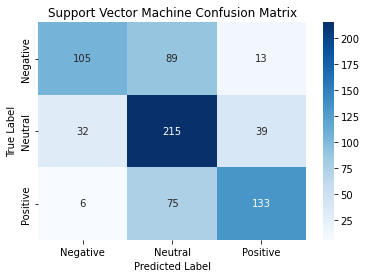

In [18]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machine Confusion Matrix')

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

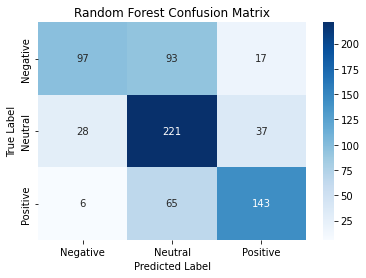

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')

Text(0.5, 1.0, 'Vader Confusion Matrix')

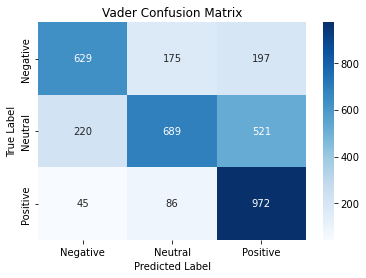

In [20]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_vd, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Vader Confusion Matrix')

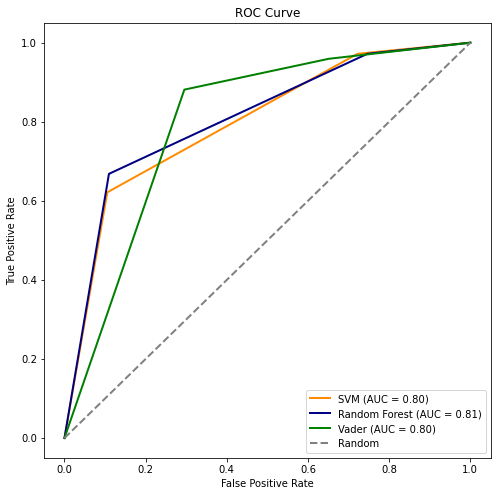

In [21]:
# ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred , pos_label= 2)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred, pos_label= 2)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve for Vader
fpr_vd, tpr_vd, _ = roc_curve(df['sentiment'],df['vader_sentiment'], pos_label= 2)
roc_auc_vd = auc(fpr_vd, tpr_vd)

# Plot ROC Curves
plt.figure(figsize=(8,8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='navy', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_vd, tpr_vd, color='green', lw=2, label=f'Vader (AUC = {roc_auc_vd:.2f})') 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

/Users/thilokreddyanugu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


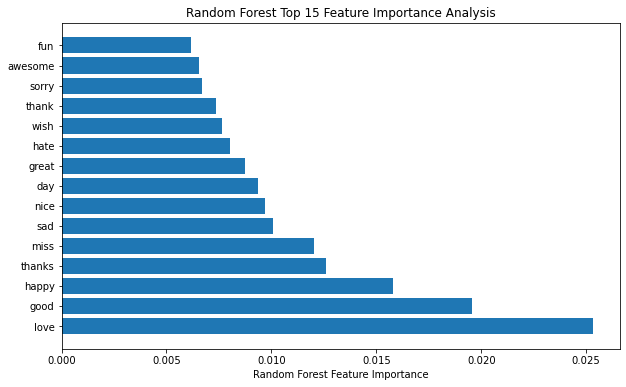

/Users/thilokreddyanugu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/thilokreddyanugu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/thilokreddyanugu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

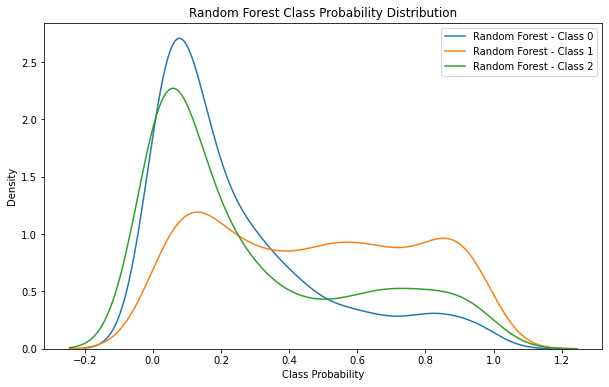

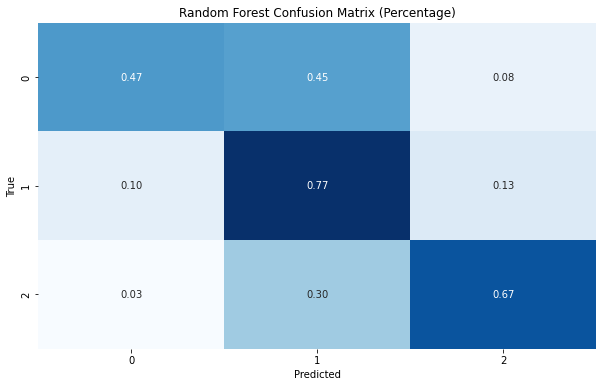

In [22]:
def plot_top_feature_importance(model, feature_names, top_n, model_name):
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = feature_importance.argsort()[::-1][:top_n]
        features = [feature_names[i] for i in sorted_idx]
        importance = feature_importance[sorted_idx]

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(importance)), importance, align="center")
        plt.yticks(range(len(importance)), features)
        plt.xlabel(f"{model_name} Feature Importance")
        plt.title(f"{model_name} Top {top_n} Feature Importance Analysis")
        plt.show()

# Class Probability Distribution
def plot_class_probability_distribution(model, X, y, model_name):
    probas = model.predict_proba(X)
    unique_classes = model.classes_

    plt.figure(figsize=(10, 6))
    for i, class_label in enumerate(unique_classes):
        sns.distplot(probas[:, i], hist=False, kde_kws={"label": f"{model_name} - Class {class_label}"})

    plt.xlabel("Class Probability")
    plt.ylabel("Density")
    plt.title(f"{model_name} Class Probability Distribution")
    plt.legend()
    plt.show()

# Error Analysis - Confusion Matrix Heatmap
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ... (Your previous code)

# Plot Feature Importance for Random Forest
top_n_features = 15  
plot_top_feature_importance(rf, vectorizer.get_feature_names(), top_n_features, 'Random Forest')

# Plot Class Probability Distribution
plot_class_probability_distribution(rf, X_test_tfidf, y_test, 'Random Forest')

# Plot Error Analysis
plot_confusion_matrix_heatmap(y_test, rf_pred, 'Random Forest')


In [23]:
def perform_cross_validation(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  
    return scores
svm_scores = perform_cross_validation(svm, X_train_tfidf, y_train)
rf_scores = perform_cross_validation(rf, X_train_tfidf, y_train)

print("SVM Cross-Validation Scores:", svm_scores)
print("Random Forest Cross-Validation Scores:", rf_scores)

SVM Cross-Validation Scores: [0.61837456 0.64664311 0.61238938 0.62831858 0.61238938]
Random Forest Cross-Validation Scores: [0.63250883 0.6590106  0.60884956 0.64424779 0.60707965]


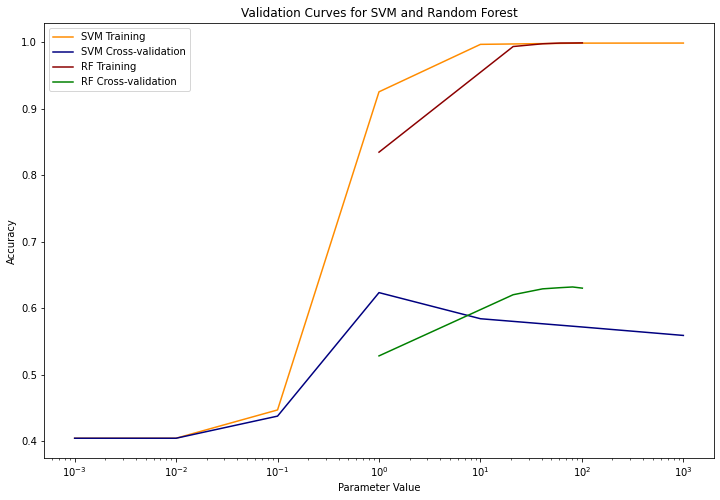

In [24]:
# Vary the 'C' parameter for SVM
param_range = np.logspace(-3, 3, 7)

# Plot validation curves for SVM and Random Forest
plt.figure(figsize=(12, 8))

# Validation curve for SVM
train_scores_svm, test_scores_svm = validation_curve(
    svm, X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_svm_mean = np.mean(train_scores_svm, axis=1)
test_scores_svm_mean = np.mean(test_scores_svm, axis=1)

plt.semilogx(param_range, train_scores_svm_mean, label="SVM Training", color="darkorange")
plt.semilogx(param_range, test_scores_svm_mean, label="SVM Cross-validation", color="navy")

# Validation curve for Random Forest
train_scores_rf, test_scores_rf = validation_curve(
    rf, X_train_tfidf, y_train, param_name="n_estimators", param_range=np.arange(1, 102, 20),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)

train_scores_rf_mean = np.mean(train_scores_rf, axis=1)
test_scores_rf_mean = np.mean(test_scores_rf, axis=1)

plt.semilogx(np.arange(1, 102, 20), train_scores_rf_mean, label="RF Training", color="darkred")
plt.semilogx(np.arange(1, 102, 20), test_scores_rf_mean, label="RF Cross-validation", color="green")

plt.title("Validation Curves for SVM and Random Forest")
plt.xlabel("Parameter Value")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

In [ ]:
# User interaction
while True:
    user_input = input("Enter a statement (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        print("Exiting the program. Goodbye!")
        break

    # Vectorize the user input
    user_input_tfidf = vectorizer.transform([user_input])

    # Predict sentiment for the user input
    user_sentiment = rf.predict(user_input_tfidf)[0]
    print(f"The sentiment of the statement '{user_input}' is {user_sentiment}")